# 1. Introduction

An Invertible Bloom Lookup Table, or *IBLT*, is a key data structure in the Graphene protocol that is used for set reconciliation between the sender's block and the receiver's mempool. An IBLT is comprised of multiple *cells*, each of which contains several fields: key, value, count, and checksum. An arbitrarily large number of items can be added to a cell as long as they are ultimately deleted by means of a *peeling process*. When the count is either 1 or -1, we can normally be certain that the key and value fields correspond to an actual item. However, when erroneous deletions are possible, those fields can contain *garbage* items (an inseparable combination of multiple valid items) even when the count is 1 or -1. The checksum field is added so that such garbage content can be detected. Currently, 32 checksum bits are used per cell in the IBLT. The purpose of this document is to explore the possibility of reducing the IBLT cell checksum field size while ensuring that decode failure rate remains low. 

# 2. Conditions Behind a Garbage Read

Let $I_s$ and $F$ denote the Graphene IBLT and Bloom filter, respectively, in block $B$. After receiving $B$, the receiver constructs her own IBLT $I_r$ by testing all transactions from her mempool $M$ against $F$, and inserting any that pass into $I_r$. She then creates a third IBLT $I_d$ from the difference $I_s - I_r$. All three IBLTs use the same number of hash functions $k$, which depends on the number of cells (the optimal number is $k=4$ [for most IBLTs](https://github.com/umass-forensics/IBLT-optimization/blob/master/iblt_params.h)). Therefore, a transaction added to any of the IBLTs will be added to $k$ different cells.

Now consider the circumstances under which a cell in $I_d$ can become corrupted. We assume that $I_s$ is always error free. The only error that can affect $I_r$ is an erroneous insertion, which occurs when transaction $T$, not in $B$, slips past filter $F$ (registers as a positive) and is inserted into $I_r$. At this point, the cell has been corrupted, but the corrupted value will not necessarily be read. The only time that a transaction is read from a cell is when the count field is either 1 or -1, which occurs with one or both of the following.
1. The number of entries in that cell initially differ by exactly 1 between IBLTs $I_s$ ans $I_r$.
2. The entries in the cell have been reduced to -1 or 1 by means of the peeling process used to remove transactions from other cells. 

From the two scenarios above, notice that the only way a corrupted cell $C_1$ containing two or more corrupt values can be read is if another cell $C_2$, holding a single corrupted value, is peeled and that peel removes one of the corrupted values from $C_2$. Suffice it to say, although it appears that the probability of reading a corrupted value is far from certain, computing this value is complex. 

# 3. Probability of Producing a Corrupted Cell

Going forward, we will assume that a cell is eventually read if it ever becomes corrupted. Therefore, we proceed by bounding the probability that any cell ever becomes corrupted. If $I_d$ has $c$ cells, then for each erroneous insertion, we expect that any given cell becomes corrupted with probability $k/c$. Now let $f$ denote the false positive rate of $F$ and suppose that there are $m$ transactions in the receiver's mempool. The probability that cell $C_i$ becomes corrupted is no greater than 
$$
p = 1 - \left(1 - f \frac{k}{c}\right)^m.
$$
Next, suppose that the checksum uses $b$ bits. This means that the probability that a given corrupted cell is not identified as corrupted is equal to $(1/2)^b$. Thus, the probability of reading garbage from cell $C_i$ is given by $p(1/2)^b$. It follows that the probability of reading garbage from *any* cell is bounded by
$$
\begin{array}{lr}
P = cp\left(\frac{1}{2}\right)^b = c \left(\frac{1}{2}\right)^b \left[1 - \left(1 - f \frac{k}{c}\right)^m\right] & (1).
\end{array}
$$

# 4. Experiments

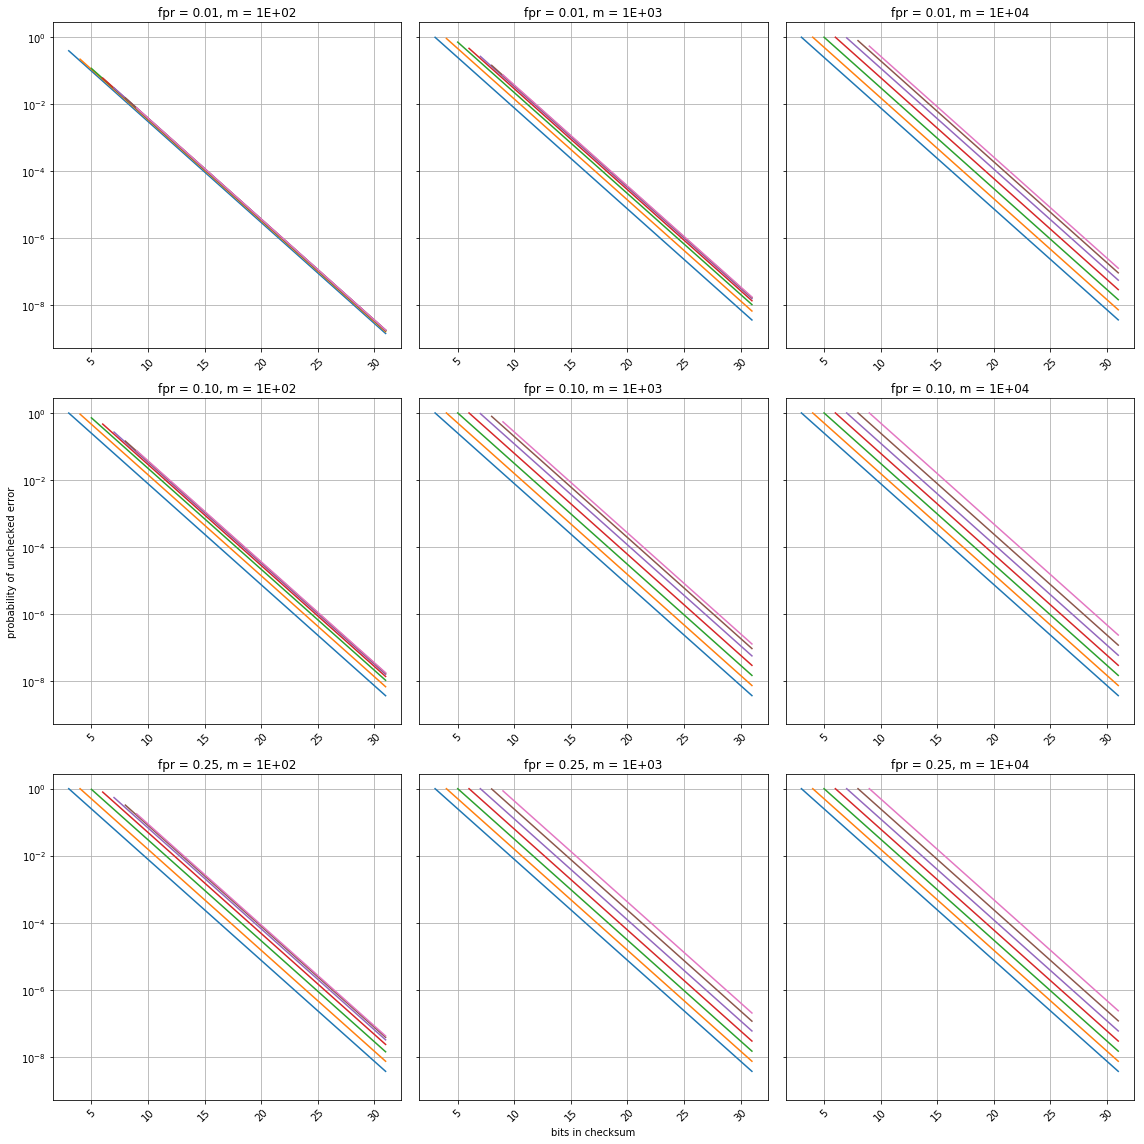

In [34]:
# setup
import numpy as np
import pylab as plt
k = 4

def prob(c, b, f, k, m):
    return c * 0.5**b * (1 - (1 - f*k/c)**m)

rows, cols = 3, 3
cs = [8, 16, 32, 64, 128, 256, 512]
f, axes = plt.subplots(rows, cols, sharey=True, figsize=(16,16))
for row, f in enumerate([0.01, 0.1, 0.25]):
    for col, m in enumerate([1e2, 1e3, 1e4]):
        axes[row, col].set_title('fpr = %0.2f, m = %2.0E' % (f, m))
        for c in cs:
            bs = range(int(np.log2(c)), 32)
            probs = [prob(c, b, f, k, m) for b in bs]
            axes[row, col].semilogy(bs, probs)
            axes[row, col].grid(True)
            plt.setp(axes[row, col].get_xticklabels(), rotation=45)
            if row == rows//2 and col == 0: axes[row, col].set(ylabel='probability of unchecked error')
            if col == cols//2 and row == rows-1: axes[row, col].set(xlabel='bits in checksum')           
plt.tight_layout()

# 5. Discussion

For clarity, we define an *unchecked error* as the event that a cell becomes corrupted, but it passes the checksum. The figures show how the probability of experiencing an unchecked error decreases exponentially with the number of bits $b$ in the checksum. In the plots, we vary the number of transactions in the receiver mempool $m$ with each column and the FPR $f$ of the Bloom filter with each row. Each of the colored curves in a given plot represent a different quantity of cells in the IBLT (with blue being fewest). Overall, we can see that adding cells increases the probability of an unchecked error (because there are more places where it can occur), and the error also increases with both $m$ and $f$.

# 5.1 Selecting Checksum Size

For a given unchecked error tolerance $\tau$, we can substitute $P = \tau$ in Equation 1 above and solve for $b$ to determine the minimum number of bits required in the checksum field to ensure an unchecked error rate no greater than $\tau$. We have
$$
b^* = \log_2 \left( c \left[1 - \left(1 - f \frac{k}{c}\right)^m\right] \right) - \log_2(\tau).
$$
A natural question is how to choose unchecked error tolerance $\tau$, which requires that we consider the consequences of an error. In the current implementation of Graphene, reading a garbage value from IBLT $I_d$ will result in a Merkle root check failure, which ultimately triggers the request of a failover block (a Compact block by default). So the worst case scenario is that the receiver will lose time after being forced to download the block using a different protocol. Therefore, a reasonable goal is to not greatly increase the existing IBLT decode failure rate, which is currently set to 0.005. We can accomplish this by choosing an unchecked error tolerance of 0.001.

The table below gives the value $b^*$ for $\tau = 0.001$ and various values of $f$, $c$, and $m$.

In [43]:
from tabulate import tabulate
tau = 0.001
k = 4
def b_star(f, c, m):
    return np.log2(c*(1 - (1 - f * k / c )**m)) - np.log2(tau)

rows = []
for c in [8, 16, 32]:
    for f in [0.01, 0.1, 0.25]:
        for m in [1e2, 1e3, 1e4]:
            rows.append((b_star(f, c, m), f, c, m))
            
print(tabulate(rows, headers=['b*', 'f', 'c', 'm']))

     b*     f    c      m
-------  ----  ---  -----
11.6229  0.01    8    100
12.9562  0.01    8   1000
12.9658  0.01    8  10000
12.9572  0.1     8    100
12.9658  0.1     8   1000
12.9658  0.1     8  10000
12.9658  0.25    8    100
12.9658  0.25    8   1000
12.9658  0.25    8  10000
11.7908  0.01   16    100
13.8426  0.01   16   1000
13.9658  0.01   16  10000
13.8462  0.1    16    100
13.9658  0.1    16   1000
13.9658  0.1    16  10000
13.9635  0.25   16    100
13.9658  0.25   16   1000
13.9658  0.25   16  10000
11.8774  0.01   32    100
14.4792  0.01   32   1000
14.9658  0.01   32  10000
14.4833  0.1    32    100
14.9658  0.1    32   1000
14.9658  0.1    32  10000
14.9042  0.25   32    100
14.9658  0.25   32   1000
14.9658  0.25   32  10000


We can see that the number of bits required to ensure unchecked error rate $\tau = 0.001$ varies significantly with the choices of $f$, $c$, and $m$. But all of these cases show that far fewer than 32 bits are required, which is the number of checksum  bits used today.